# EMSL Summer School
## Day 1 Afternoon Session: Machine Learning Examples
### Random Forest Model for Classifying Site Vegetation
#### SOLUTION

## Problem Statement

**The Challenge:** Land managers, agricultural planners, and environmental scientists need to predict what type of vegetation a soil sample can support based on its chemical and physical properties. This information is crucial for:
- **Agricultural planning**: Determining optimal crop selection and land use
- **Remote sensing validation**: Ground-truthing satellite vegetation classifications
- **Construction projects**: Assessing site suitability and environmental impact
- **Ecosystem restoration**: Selecting appropriate native vegetation for rehabilitation

Traditional vegetation assessment requires extensive field surveys and long-term monitoring. **Can we use machine learning to predict vegetation type** directly from readily available soil measurements?

**Your Dataset:** We're working with *real* EMSL data from the [Molecular Observation Network (MONet)](https://www.emsl.pnnl.gov/monet#mission) program (`merged_soil_data_expanded.csv`) that contains:
- Chemical properties (carbon content, pH levels, nutrient concentrations)
- Physical measurements (texture, moisture, density)
- Environmental factors (location, climate data)
- Sample metadata (collection methods, timing)
- **Target variable**: Current vegetation type (`cur_vegetation`) supported by each soil sample

**Your Mission:** Build a Random Forest classifier that can accurately predict vegetation categories from soil properties. Random Forest is an excellent algorithm for this task because it:
- Handles mixed data types well
- Provides feature importance rankings
- Is robust to outliers and missing values (common in ecology!)
- Offers good interpretability for scientists

We'll practice data preprocessing, model training, evaluation, and interpretation - skills essential for any machine learning project. By the end, you should have a working classifier and understand which soil properties are most important for supporting different vegetation types.

**Learning Goals:**
- Master the machine learning workflow
- Understand Random Forest classification
- Interpret model results for scientific insights
- Apply best practices for model evaluation

## Load, Clean and Visualize Your Data

Let's start by exploring the dataset to understand what we're working with. We'll examine the vegetation types (column `cur_vegetation`) we're trying to predict and get a sense of the soil properties that might help us make these predictions.

**Task:** `import` appropriate libraries and load your dataframe using `read_csv`. Check on the dimensions of the data, and make a barplot of the distribution of vegetation types. Other plots or explorations you might find helpful are welcome. **You will need to drop rows that do not have an entry for the current vegetation type**.

Dataset shape: (495, 126)

First few rows:
    sample_name     mbc     mbn           flag_mbc flag_mbn  density  carbon  \
0  60846_12_BTM   14.44   14.44  'High_Background'      NaN     1.05    1.72   
1  60846_12_BTM  128.26  128.26  'High_Background'      NaN     1.05    1.72   
2  60846_12_BTM  123.68  123.68  'High_Background'      NaN     1.05    1.72   
3  60846_12_TOP  205.81  205.81  'High_Background'      NaN     0.53    8.18   
4  60846_12_TOP  238.05  238.05  'High_Background'      NaN     0.53    8.18   

   nitrogen  kj_nitro  sulfur  ...  annual_precpt_value_mm  \
0      0.10      0.10   0.012  ...                  1370.0   
1      0.10      0.10   0.012  ...                  1370.0   
2      0.10      0.10   0.012  ...                  1370.0   
3      0.56      0.56   0.066  ...                  1370.0   
4      0.56      0.56   0.066  ...                  1370.0   

   annual_temp_value_C  season_precpt_value_in  season_temp_value_Â°F  \
0                 18.5        

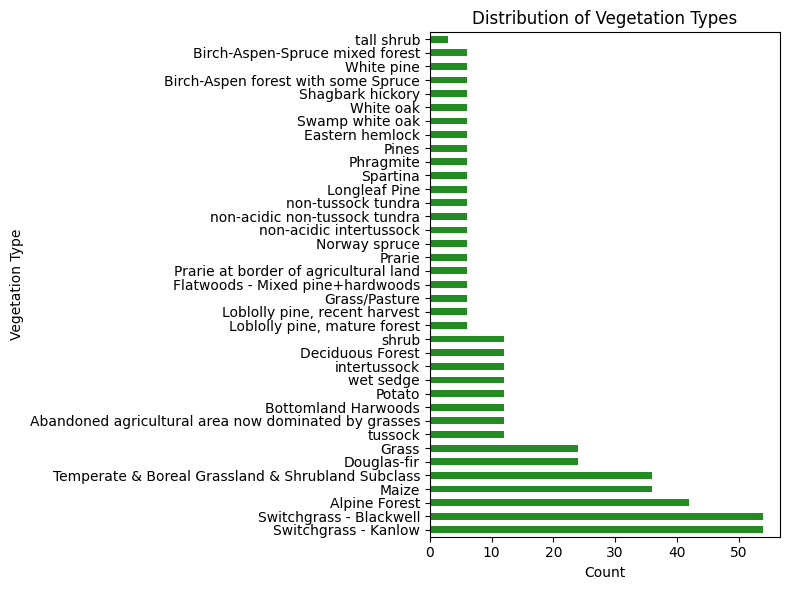

In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data and drop rows with missing vegetation types
df = pd.read_csv('../data/merged_soil_data_expanded.csv') 
df = df.dropna(subset=['cur_vegetation']).copy() ## copy() ensures that we work with a new DataFrame

# Display the first few rows and shape of the dataset
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Examine our target variable - how many unique vegetation types do we have?
print(f"\nVegetation types (cur_vegetation):")
print(df['cur_vegetation'].value_counts())

# Look at some key soil properties based on the available columns
soil_properties = ['carbon', 'ph_h2o', 'nitrogen', 'clay_percent', 'sand_percent']
available_props = [col for col in soil_properties if col in df.columns]
print(f"\nKey soil properties available: {available_props}")
print("\nSummary of soil properties:")
print(df[available_props].describe())

# Check for missing values in those key columns
print(f"\nMissing values in key columns:")
print(df[['cur_vegetation'] + available_props].isnull().sum())

# Simple visualization: barplot of vegetation distribution
# You may wish to plot the vegetation types on the y-axis for better readability
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
vegetation_counts = df['cur_vegetation'].value_counts()
vegetation_counts.plot(kind='barh', ax=ax, color='forestgreen')
ax.set_title('Distribution of Vegetation Types')
ax.set_xlabel('Count')
ax.set_ylabel('Vegetation Type')

plt.tight_layout()
plt.show()

## Build Your Random Forest Classifier

We are going to build & train a Random Forest model. This is a good choice for environmental data because it can handle mixed data types, provides feature importance rankings, and is robust to outliers.

**Your Goal:** Create a Random Forest classifier using `RandomForestClassifier` from `scikit-learn` (read more about the module [here](https://scikit-learn.org/stable/supervised_learning.html)) that can predict vegetation type (`cur_vegetation`) from the metadata and observations contained in the EMSL MONet dataset. 

**Task:** You'll need to do the following:
1. **Prepare your data** by selecting numeric features and handling missing values - we cleaned it as well as we could, but this is a good exercise since messy data is common in the real world! You can choose if or how you'd like to handle missing data, and which predictor columns you'd like to include or exclude. **The choices you make here will make your model perform differently from others**. You'll likely want to exclude unique identifying columns such as `sample_name` or `replicate_number` -- why?.
2. Split the data into training and testing sets.
3. Configure the Random Forest model with appropriate hyperparameters - you can start with the defaults in `RandomForestClassifier`!
4. Train the model and make predictions.
5. Evaluate performance using accuracy, classification reports, and confusion matrices (and visualize them!)

In [14]:
# Import ensemble, model_selection, metrics from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Select numeric features only for predictive parameters (exclude identifiers and target)
exclude_cols = ['sample_name', 'replicate_number', 'cur_vegetation']
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Create feature matrix (X) and target vector (y)
X = df[feature_cols].copy()
y = df['cur_vegetation'].copy()

# Handle missing values in features (here we fill with median)
for col in X.columns:
    X[col] = X[col].fillna(X[col].median())

# print the shapes and counts of the features and target - do these seem appropriate?
print(f"\nFeature matrix shape: {X.shape}")
print(f"Features selected: {len(feature_cols)}")
print(f"Samples available: {len(X)}")
print(f"Vegetation classes: {y.nunique()}")

# Step 2: Split the data into training and testing sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,      # 30% for testing
    random_state=42,    # For reproducible results
    stratify=y          # Maintain class proportions
)

# Display the shapes of the training and testing sets - do they match your specifications?
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Step 3: Create and configure Random Forest model using RandomForestClassifier
# You may use the default parameters or customize them 
rf_model = RandomForestClassifier(
    n_estimators=100,       # Number of trees in the forest
    max_depth=10,           # Maximum depth of each tree
    min_samples_split=5,    # Minimum samples required to split a node
    min_samples_leaf=2,     # Minimum samples required at a leaf node
    random_state=42,        # For reproducible results
    n_jobs=-1              # Use all available processors
)

# Step 4: Train the model using rf_model.fit()
print("Training Random Forest model...")
rf_model.fit(X_train, y_train)

# Step 5: Make predictions using rf_model.predict()
y_pred = rf_model.predict(X_test)

# Step 6: Evaluate the model using accuracy_score, classification_report, and confusion_matrix
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

c:\Users\kapu336\Documents\CAM\ai-summercamp\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kapu336\Documents\CAM\ai-summercamp\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kapu336\Documents\CAM\ai-summercamp\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kapu336\Documents\CAM\ai-summercamp\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kapu336\Documents\CAM\ai-summercamp\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Us


Feature matrix shape: (495, 97)
Features selected: 97
Samples available: 495
Vegetation classes: 37
Training samples: 346
Testing samples: 149
Training Random Forest model...

Model Accuracy: 1.0000

Detailed Classification Report:
                                                      precision    recall  f1-score   support

Abandoned agricultural area now dominated by grasses       1.00      1.00      1.00         3
                                       Alpine Forest       1.00      1.00      1.00        13
                 Birch-Aspen forest with some Spruce       1.00      1.00      1.00         2
                     Birch-Aspen-Spruce mixed forest       1.00      1.00      1.00         2
                                 Bottomland Harwoods       1.00      1.00      1.00         3
                                    Deciduous Forest       1.00      1.00      1.00         3
                                         Douglas-fir       1.00      1.00      1.00         7
              

## Visualize and Evaluate Your Model

Now that we've trained our Random Forest classifier, it's time to evaluate how well it performs and understand what drives its predictions, so we'll make some common plots. Most of these can be generated using built-in functionality from `sklearn`.

**Task:** Create comprehensive visualizations to 1) assess model performance and 2) gain insights into which soil properties are most important for predicting vegetation types.

**The Key Visualizations:**

1. **Confusion Matrix** - Shows prediction accuracy for each vegetation class. Perfect predictions appear on the diagonal, while misclassifications appear off-diagonal. This helps identify which classes are easily confused with each other.

2. **Feature Importance Bar Chart** - Displays the top 15 most important soil properties that drive vegetation predictions. Higher importance values indicate features that contribute more to the model's decision-making process. Be sure to check out `column_descriptions.csv ` for definitions of cryptically-labeled columns. *Remember: if a feature was not in your original prediction matrix, there's no way for it to appear here*.

3. **Class Distribution Comparison** - Compares the actual vs predicted counts for each vegetation type. This reveals whether the model maintains the original class balance across the dataset or shows bias toward predicting certain vegetation types.

4. **Classification Report** - This is a built-in table from `sklearn` that provides detailed performance metrics for each vegetation class. If you're curious, the columns in this table are
   - **Precision**: Of all predictions for this class, how many were correct? (avoid false alarms)
   - **Recall**: Of all actual samples of this class, how many were correctly identified? (avoid missing cases) 
   - **F1-Score**: Balanced combination of precision and recall (via harmonic mean)
   - **Support**: Number of actual samples of each class in the test set

Together, these visualizations provide a complete picture of model performance and help us understand both where the model succeeds and where it might need improvement.

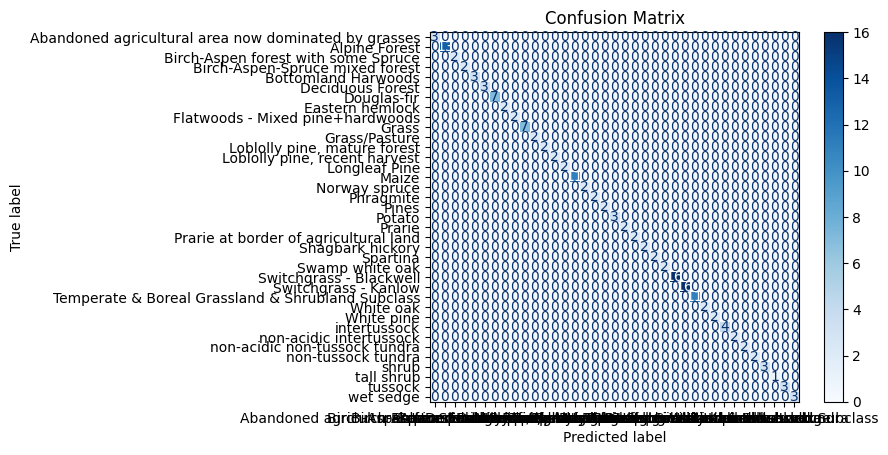

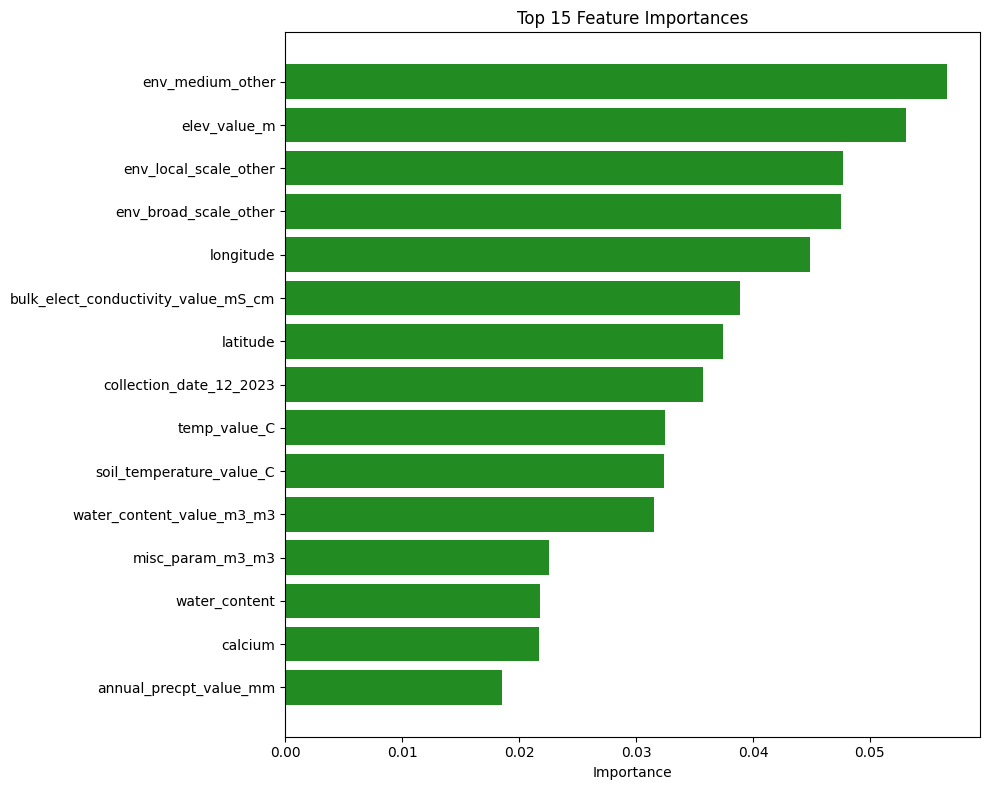


Top 10 Most Important Features:
 1. env_medium_other               0.0566
 2. elev_value_m                   0.0531
 3. env_local_scale_other          0.0477
 4. env_broad_scale_other          0.0476
 5. longitude                      0.0449
 6. bulk_elect_conductivity_value_mS_cm 0.0389
 7. latitude                       0.0374
 8. collection_date_12_2023        0.0357
 9. temp_value_C                   0.0325
10. soil_temperature_value_C       0.0324


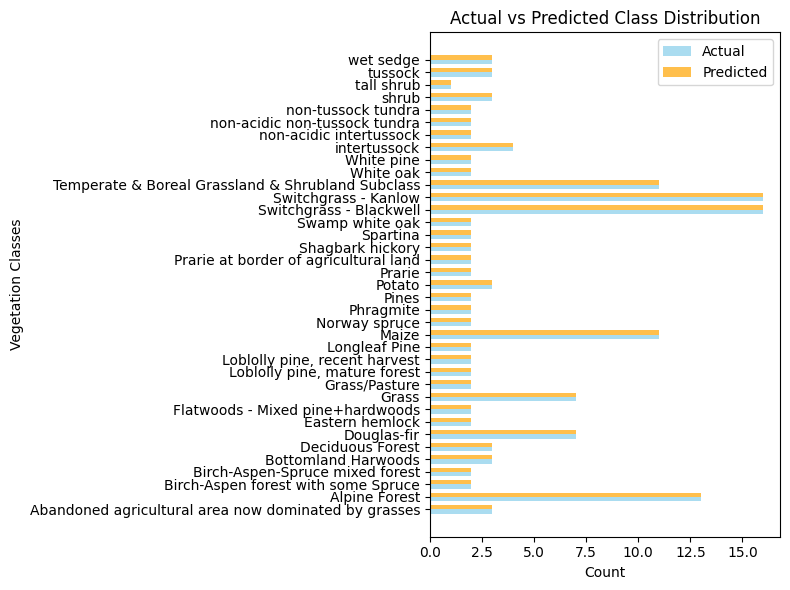


=== DETAILED CLASSIFICATION REPORT ===
                                                      precision    recall  f1-score   support

Abandoned agricultural area now dominated by grasses       1.00      1.00      1.00         3
                                       Alpine Forest       1.00      1.00      1.00        13
                 Birch-Aspen forest with some Spruce       1.00      1.00      1.00         2
                     Birch-Aspen-Spruce mixed forest       1.00      1.00      1.00         2
                                 Bottomland Harwoods       1.00      1.00      1.00         3
                                    Deciduous Forest       1.00      1.00      1.00         3
                                         Douglas-fir       1.00      1.00      1.00         7
                                     Eastern hemlock       1.00      1.00      1.00         2
                    Flatwoods - Mixed pine+hardwoods       1.00      1.00      1.00         2
                   

In [15]:
# Import sklearn visualization tools 
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.inspection import permutation_importance

# 1. Plot confusion matrix using ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                                    display_labels=rf_model.classes_,
                                                    cmap='Blues', 
                                                    values_format='d')
plt.title('Confusion Matrix')
plt.show()

# 2. Plot barplot feature importance: you can get a table of these from rf_model.feature_importances_
importances = rf_model.feature_importances_
feature_names = feature_cols

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot top 15 features
plt.figure(figsize=(10, 8))
top_n = 15
plt.title(f"Top {top_n} Feature Importances")
plt.barh(range(top_n), importances[indices[:top_n]], color='forestgreen')
plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]])
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 3. Print top 10 most important features
print(f"\nTop 10 Most Important Features:")
for i in range(10):
    idx = indices[i]
    print(f"{i+1:2d}. {feature_names[idx]:30s} {importances[idx]:.4f}")

# 3. Plot a barplot of the proportional distribution of actual vs predicted classes
# This will help visualize how well the model predicts each class
plt.figure(figsize=(8, 6))

actual_counts = pd.Series(y_test).value_counts().sort_index()
pred_counts = pd.Series(y_pred).value_counts().sort_index()

y_pos = np.arange(len(actual_counts))
height = 0.35

plt.barh(y_pos - height/2, actual_counts.values, height, label='Actual', alpha=0.7, color='skyblue')
plt.barh(y_pos + height/2, pred_counts.values, height, label='Predicted', alpha=0.7, color='orange')
plt.ylabel('Vegetation Classes')
plt.xlabel('Count')
plt.title('Actual vs Predicted Class Distribution')
plt.yticks(y_pos, actual_counts.index)
plt.legend()

plt.tight_layout()
plt.show()

# 4. Classification Report (sklearn built-in via classification_report)
print("\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=rf_model.classes_))


## Interpretation and Next Steps

You've built and evaluated a Random Forest classifier for predicting vegetation types from soil properties. Now let's think about how to improve your model and what your results tell us about the machine learning process.

### Food for Thought

**Model Performance Analysis:**
- What was your overall accuracy? How does this compare to random guessing (1/number_of_classes)?
- Which vegetation types were hardest to classify correctly? What does this suggest about your feature selection or class balance?
- Did your model show bias toward predicting certain vegetation types more often than others? How might you address this?

**Feature Engineering & Selection:**
- Which soil properties were most important for predictions? Were there any surprising results?
- How many features did you use? What would happen if you only used the top 10 most important features?
- Are there features with very low importance that you could remove to simplify your model?
- Could you create new features by combining existing ones (e.g., ratios, interactions)?

**Model Tuning & Experimentation:**
- How did your hyperparameters (n_estimators, max_depth, etc.) affect performance? Try changing them!
- What happens if you use different train/test split ratios (e.g., 80/20 vs 70/30)?
- How does your model perform with different missing value strategies (mean vs median vs mode)?
- Could you improve performance by handling class imbalance (e.g., using class weights)?

**Evaluation & Validation:**
- Are you satisfied with your accuracy, or do you need higher performance for your use case?
- Which metrics matter most: precision, recall, or F1-score? This depends on your application!
- How confident are you that your model will work on completely new data?
- What additional validation techniques could you use (cross-validation, holdout sets)?

**Real-World ML Considerations:**
- How would you deploy this model in practice? What data would you need to collect?
- What are the costs of false positives vs false negatives in your predictions?
- How would you monitor model performance over time and retrain when needed?
- What would you do if you encountered a completely new vegetation type not in your training data?

### Next Steps for Model Improvement
- **Hyperparameter tuning**: Use GridSearchCV or RandomizedSearchCV to optimize your Random Forest parameters
- **Feature engineering**: Create new features, handle missing data differently, or try feature scaling
- **Algorithm comparison**: Test other classifiers (SVM, Gradient Boosting, Neural Networks) on the same data
- **Ensemble methods**: Combine multiple models for potentially better performance
- **Data collection**: Identify which types of samples would most improve your training data
- **Cross-validation**: Use k-fold cross-validation for more robust performance estimates

The key to successful machine learning is iteration: try different approaches, measure their impact, and continuously improve your model based on the results!
